# **PPO with L2 Norm**

In [1]:
import numpy as np
import gymnasium as gym
from coverage_env import CoverageEnv
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from torch.optim import AdamW

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import matplotlib.pyplot as plt

In [2]:
env_0 = CoverageEnv(curriculum=0)
env_1 = CoverageEnv(curriculum=1)
env_2 = CoverageEnv(curriculum=2)
env_3 = CoverageEnv(curriculum=3)
env_4 = CoverageEnv(curriculum=4)

In [3]:
policy_kwargs = dict(
    optimizer_class  = AdamW,
    optimizer_kwargs = dict(
        weight_decay = 1e-4
    )
)

# **Environment 0**

In [4]:
model = PPO(
    "MlpPolicy",
    env_0,
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    policy_kwargs = policy_kwargs,
    tensorboard_log="logs/ppo/mlp/l2/coverage_lvl0",
)

# train for 50k timesteps
model.learn(total_timesteps=500_000)

# save it
model.save("models/ppo/l2/mlp_coverage_lvl0")


/home/joaolucasmbc/mambaforge/envs/rl-cpp/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo/mlp/l2/coverage_lvl0/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 151      |
|    ep_rew_mean     | -112     |
| time/              |          |
|    fps             | 1949     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 160        |
|    ep_rew_mean          | -121       |
| time/                   |            |
|    fps                  | 673        |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01761543 |
|    clip_fraction        | 0.101      |
|    clip_range           |

/home/joaolucasmbc/mambaforge/envs/rl-cpp/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/ppo/l2' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


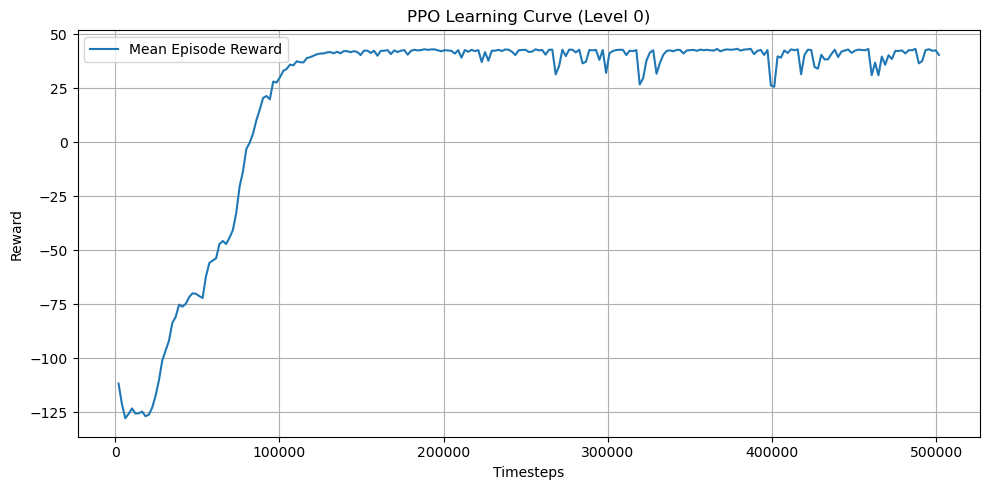

In [5]:
log_dir = "logs/ppo/mlp/l2/coverage_lvl0/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

/home/joaolucasmbc/mambaforge/envs/rl-cpp/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 19.35 ± 73.13


# **Environment 1**

In [7]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/l2/mlp_coverage_lvl0.zip", 
    env=env_1, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    policy_kwargs = policy_kwargs,
    tensorboard_log="logs/ppo/mlp/l2/coverage_lvl1",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_1, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -197.75 ± 5.36


In [8]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/l2/mlp_coverage_lvl1")

Logging to logs/ppo/mlp/l2/coverage_lvl1/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 1975     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -198         |
| time/                   |              |
|    fps                  | 572          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0018327868 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0598      |
|    explai

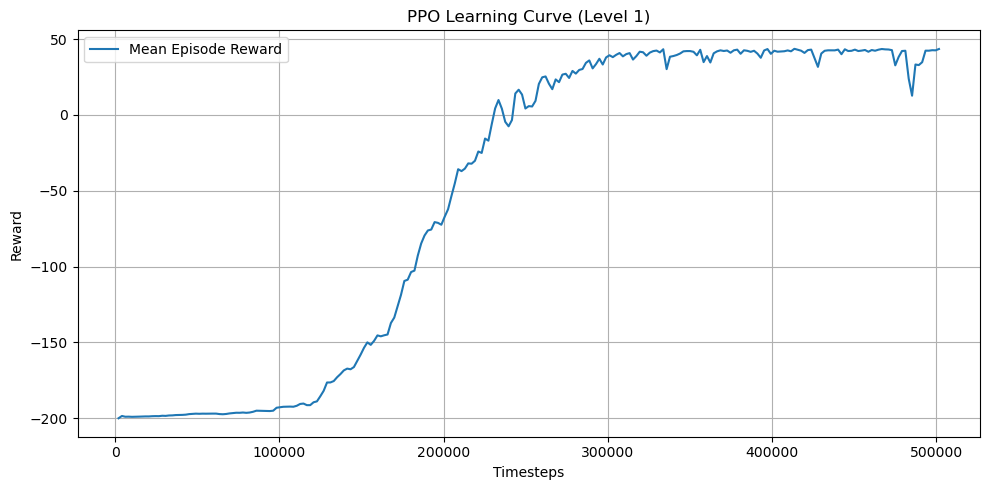

In [9]:
log_dir = "logs/ppo/mlp/l2/coverage_lvl1/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_0,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 0: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 1: 44.45 ± 2.80
Fine-tuned performance on level 0: -200.00 ± 0.00


# **Environment 2**

In [11]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/l2/mlp_coverage_lvl1.zip", 
    env=env_2, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    policy_kwargs = policy_kwargs,
    tensorboard_log="logs/ppo/mlp/l2/coverage_lvl2",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_2, 
    n_eval_episodes=20, 
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -200.00 ± 0.00


In [12]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/l2/mlp_coverage_lvl2")

Logging to logs/ppo/mlp/l2/coverage_lvl2/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 1892     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 518         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015012253 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance  

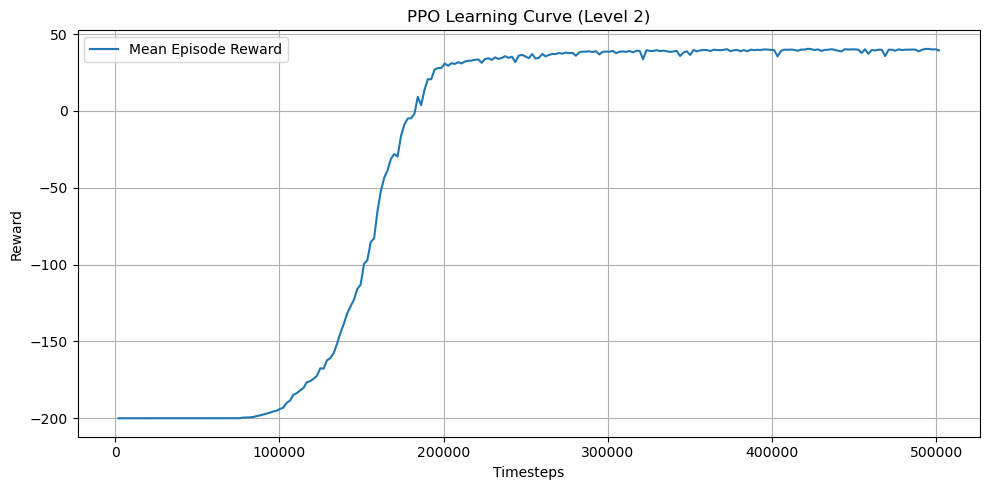

In [13]:
log_dir = "logs/ppo/mlp/l2/coverage_lvl2/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 2)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_1,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 1: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 2: 40.55 ± 2.38
Fine-tuned performance on level 1: -196.55 ± 4.48


# **Environment 3**

In [15]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/l2/mlp_coverage_lvl2.zip", 
    env=env_3, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    policy_kwargs = policy_kwargs,
    tensorboard_log="logs/ppo/mlp/l2/coverage_lvl3",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_3, 
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -199.40 ± 1.80


In [16]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/l2/mlp_coverage_lvl3")

Logging to logs/ppo/mlp/l2/coverage_lvl3/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -198     |
| time/              |          |
|    fps             | 1927     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -199        |
| time/                   |             |
|    fps                  | 496         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.022518774 |
|    clip_fraction        | 0.0331      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0756     |
|    explained_variance  

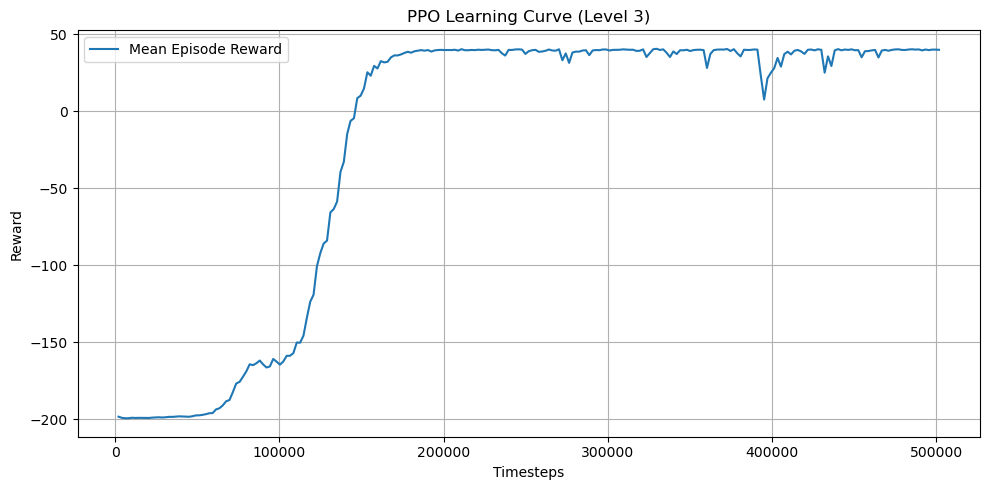

In [17]:
log_dir = "logs/ppo/mlp/l2/coverage_lvl3/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 3)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_2,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 2: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 3: 39.75 ± 1.64
Fine-tuned performance on level 2: -200.00 ± 0.00


# **Environment 4**

In [21]:
# Load the pretrained model from curriculum 0
model = PPO.load(
    "models/ppo/l2/mlp_coverage_lvl3.zip", 
    env=env_4, 
    learning_rate = 1e-4,
    n_steps       = 2048,
    batch_size    = 64,
    n_epochs      = 10,
    gamma         = 0.99,
    gae_lambda    = 0.95,
    clip_range    = 0.2,
    ent_coef      = 0.01,
    vf_coef       = 0.5,
    max_grad_norm = 0.5,
    verbose       = 1,
    policy_kwargs = policy_kwargs,
    tensorboard_log="logs/ppo/mlp/l2/coverage_lvl4",
    # Let the model continue training to see if it carries the learning
    exploration_initial_eps=0.05,
    exploration_final_eps=0.05,
)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(
    model, 
    env_4, 
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Mean reward: -200.00 ± 0.00


In [22]:
# Continue training on level 1
model.learn(total_timesteps=500_000)

# Save the fine-tuned model
model.save("models/ppo/l2/mlp_coverage_lv4")

Logging to logs/ppo/mlp/l2/coverage_lvl4/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 1891     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 567         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.059920006 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.121      |
|    explained_variance  

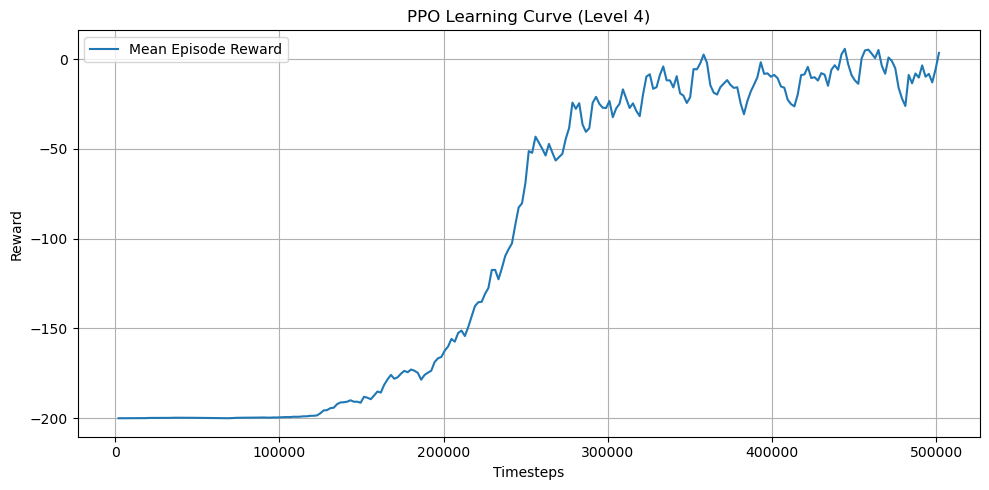

In [23]:
log_dir = "logs/ppo/mlp/l2/coverage_lvl4/PPO_1"
run_id = os.listdir(log_dir)[0]
event_path = os.path.join(log_dir, run_id)

# Load the TensorBoard logs
event_acc = EventAccumulator(event_path)
event_acc.Reload()

# Get 'rollout/ep_rew_mean' scalar events
rewards = event_acc.Scalars("rollout/ep_rew_mean")

# Extract steps and reward values
steps = [event.step for event in rewards]
reward_values = [event.value for event in rewards]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, reward_values, label="Mean Episode Reward")
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("PPO Learning Curve (Level 4)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
mean_reward, std_reward = evaluate_policy(
    model,
    env_4,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 4: {mean_reward:.2f} ± {std_reward:.2f}")


mean_reward, std_reward = evaluate_policy(
    model,
    env_3,
    n_eval_episodes=20,
    deterministic=True,
)
print(f"Fine-tuned performance on level 3: {mean_reward:.2f} ± {std_reward:.2f}")

Fine-tuned performance on level 4: -80.10 ± 105.77
Fine-tuned performance on level 3: -199.10 ± 3.30


# **Full Graph**